# SDF Estimation as the sample Markowitz portfolio of factors
Essentially trying to replicate the basic results in `Didisheim, Ke, Kelly, and Malamud - APT or AIPT? The Surprising Dominance of Large Factors Models'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# 0. Load data

In [2]:
# load Fama-French factors
factors = pd.read_csv('FF_6factors.csv')
factors.head()

,date,Mkt-RF,SMB,HML,RMW,CMA,RF,MOM
0,196307,-0.39,-0.41,-0.97,0.68,-1.18,0.27,0.90
1,196308,5.07,-0.80,1.80,0.36,-0.35,0.25,1.01
2,196309,-1.57,-0.52,0.13,-0.71,0.29,0.27,0.19
3,196310,2.53,-1.39,-0.10,2.80,-2.01,0.29,3.12
4,196311,-0.85,-0.88,1.75,-0.51,2.24,0.27,-0.74


In [5]:
# Dealing with the index
factors.index = pd.to_datetime(factors['date'], format='%Y%m')
factors=factors.drop('date',axis=1)
factors.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF,MOM
date,,,,,,,
1963-07-01,-0.39,-0.41,-0.97,0.68,-1.18,0.27,0.90
1963-08-01,5.07,-0.80,1.80,0.36,-0.35,0.25,1.01
1963-09-01,-1.57,-0.52,0.13,-0.71,0.29,0.27,0.19
1963-10-01,2.53,-1.39,-0.10,2.80,-2.01,0.29,3.12
1963-11-01,-0.85,-0.88,1.75,-0.51,2.24,0.27,-0.74


In [7]:
# save risk-free rate in case and drop it from the factors dataframe
Rf = factors['RF']
factors = factors.drop('RF',axis=1)

In [67]:
# Now load the test assets for the pricing errors
# These are the 25 portfolios sorted on size and BM from Kenneth French website
testassets = pd.read_csv('25_Portfolios_5x5.csv')
testassets.index = pd.to_datetime(testassets['date'], format='%Y%m')
testassets=testassets.drop('date',axis=1)
testassets.head()

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
date,,,,,,,,,,,,,,,,,,,,,
1963-07-01,1.1307,-0.3091,0.7079,0.1062,-1.3211,-1.8071,0.1899,-1.0105,-1.9644,-1.1889,...,-0.9806,-1.6781,-1.9184,-1.5741,-1.8567,0.1547,0.4833,1.2286,-0.5862,-1.1026
1963-08-01,4.2370,1.3834,1.4977,2.3755,4.7567,5.5665,4.5191,4.4424,4.4188,8.2329,...,5.4259,4.7306,6.2332,7.6782,5.3469,5.7691,4.2550,4.5936,8.2831,6.3824
1963-09-01,-2.8878,0.6263,-1.0204,-1.6000,-0.4320,-4.0502,-1.5034,-0.8798,-1.1812,-2.9149,...,-2.7974,-2.0801,-1.7800,-3.9639,-1.9943,-1.3595,-0.8054,-0.8135,-0.2145,-3.4963
1963-10-01,1.2885,-0.7071,1.3132,0.0855,2.3988,1.1916,4.2342,2.3524,2.2012,3.9335,...,-0.3902,0.6829,2.6229,4.8492,0.6113,5.3339,1.7427,-0.2469,2.3915,0.4857
1963-11-01,-3.3751,-3.7534,-1.8055,-1.0487,-1.0538,-4.2561,-1.7534,-0.7809,-0.1002,-0.1132,...,-0.8798,-0.6434,-0.7933,1.3610,3.5388,-1.2556,1.0072,-1.7425,-2.0838,1.3455


# 1. SDF Estimation

## 1.1. Full sample

In [10]:
# Compute the sample moments of the factors
mu_F = factors.mean(axis=0)
sigma_F = factors.cov()

In [12]:
factors.mean(axis=0)

Mkt-RF    0.583293
SMB       0.197127
HML       0.277480
RMW       0.284946
CMA       0.256626
MOM       0.610366
dtype: float64

### Note
Deepseek gave me the traditional Markowitz optimization portfolio weights, which differ from the solution of the paper that is uncentered

Look at DeepSeek's discussion to refresh

w_F_ds = np.linalg.inv(sigma_F)@mu_F 


In [15]:
# Computing the SDF portfolio and the SDF
w_F=np.linalg.inv((factors.values.T @ factors.values) / factors.shape[0])@factors.mean(axis=0)
sdf_port = factors.values @ w_F
sdf = 1 - sdf_port
sdf_df = pd.DataFrame({'SDF':sdf,'PORT':sdf_port})
sdf_df.index = factors.index
sdf_df.describe()

,SDF,PORT
count,738.000000,738.000000
mean,0.893148,0.106852
std,0.309134,0.309134
min,-0.691728,-1.545126
25%,0.728332,-0.059763
50%,0.890780,0.109220
75%,1.059763,0.271668
max,2.545126,1.691728


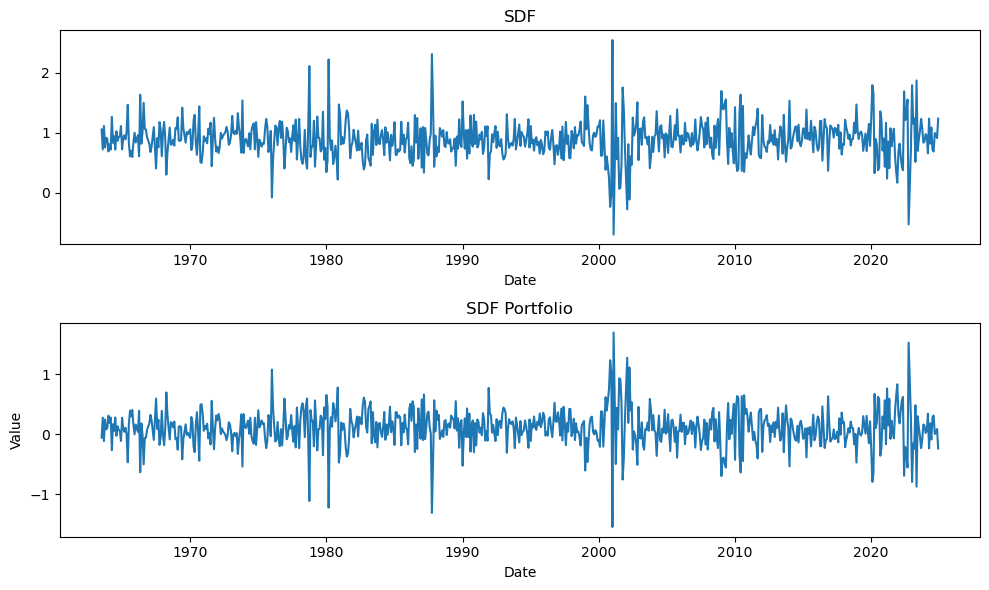

In [17]:
# Plotting the SDF and SDF portfolio
fig, axes = plt.subplots(2, 1, figsize=(10, 6))  # 

axes[0].plot(sdf_df['SDF'])
axes[0].set_title('SDF')
axes[0].set_xlabel('Date')  

axes[1].plot(sdf_df['PORT'])
axes[1].set_title('SDF Portfolio')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')

plt.tight_layout()
plt.show()

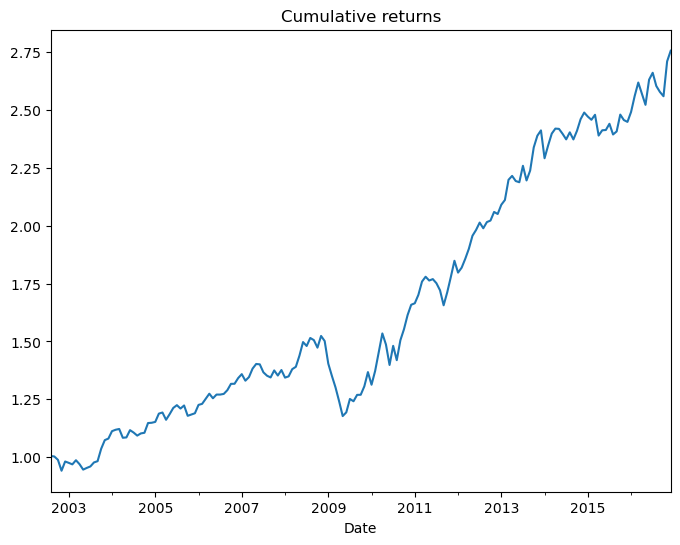

In [71]:
# computing metrics
sharpe_sdf_port = np.sqrt(12)*sdf_port.mean()/sdf_port.std()

# cumulative SDF returns from August 2002 to December 2016 (to match Figure 3 in the paper)
# index is a DatetimeIndex, so cannot slice it using a string command
start_date = pd.to_datetime('2002-08-01')
end_date = pd.to_datetime('2016-12-31')

# standardize SDF portfolio return volatility
sig_sdf_port = np.sqrt(12)*sdf_port.std()
sdf_port_scaled = sdf_port*(.1/sig_sdf_port)
sdf_df['PORT_s'] = sdf_port_scaled
cumulative_product = (sdf_df.loc[start_date:end_date,'PORT_s']+1).cumprod()

cumulative_product.plot(title="Cumulative returns",figsize=(8,6))
plt.xlabel("Date")
plt.show()

In [21]:
# checking the standardization of volatility
sdf_port_scaled.std()*np.sqrt(12)

0.1

### Computing the conditional expectation of the SDF

In [446]:
from xgboost import XGBRegressor

# Create lagged features
lags = 3
X = np.column_stack([sdf_df['SDF'].iloc[i:-lags+i] for i in range(lags)])
y = sdf_df['SDF'].iloc[lags:]

model = XGBRegressor().fit(X, y)
forecast = model.predict(X[-1:])  # E_t[x_{t+1}]

In [448]:
forecast

array([1.1811228], dtype=float32)

## 1.2. Rolling sample 

Analysis is a rolling-out-of-sample prediction  
Use 30 years (360 months) of data to estimate the parameters, and then forecast the next month

In [25]:

T = factors.shape[0]
window_size = 360  
sdf_OOS = np.full(T, np.nan)  # Store out-of-sample SDF returns
sdf_port_OOS = np.full(T, np.nan)
weights_est = np.full((T-window_size,factors.shape[1]),np.nan) # store estimated weights

for t in range(window_size, T):
    # Extract the rolling window of factors (t-window_size : t-1)
    window_factors = factors.iloc[t - window_size : t] # IMPORTANT: Python slicing is end-exclusive !!!
    
    # Compute w_F = E[F_t F_t']^{-1} E[F_t] for the window
    cov_inv = np.linalg.inv((window_factors.values.T @ window_factors.values) / window_size)
    w_F = cov_inv @ window_factors.mean(axis=0).values
    weights_est[t - window_size,:]=w_F
    
    # Out-of-sample SDF portfolio return for time t (next month)
    sdf_port_t = factors.iloc[t].values @ w_F
    sdf_port_OOS[t] = sdf_port_t
    sdf_OOS[t] = 1 - sdf_port_t  # SDF at time t

# Convert to a pandas Series for convenience
sdf_OOS = pd.Series(sdf_OOS, index=factors.index)
sdf_port_OOS = pd.Series(sdf_port_OOS, index=factors.index)
sdf_df['sdf_OOS'] = sdf_OOS
sdf_df['sdf_port_OOS'] = sdf_port_OOS

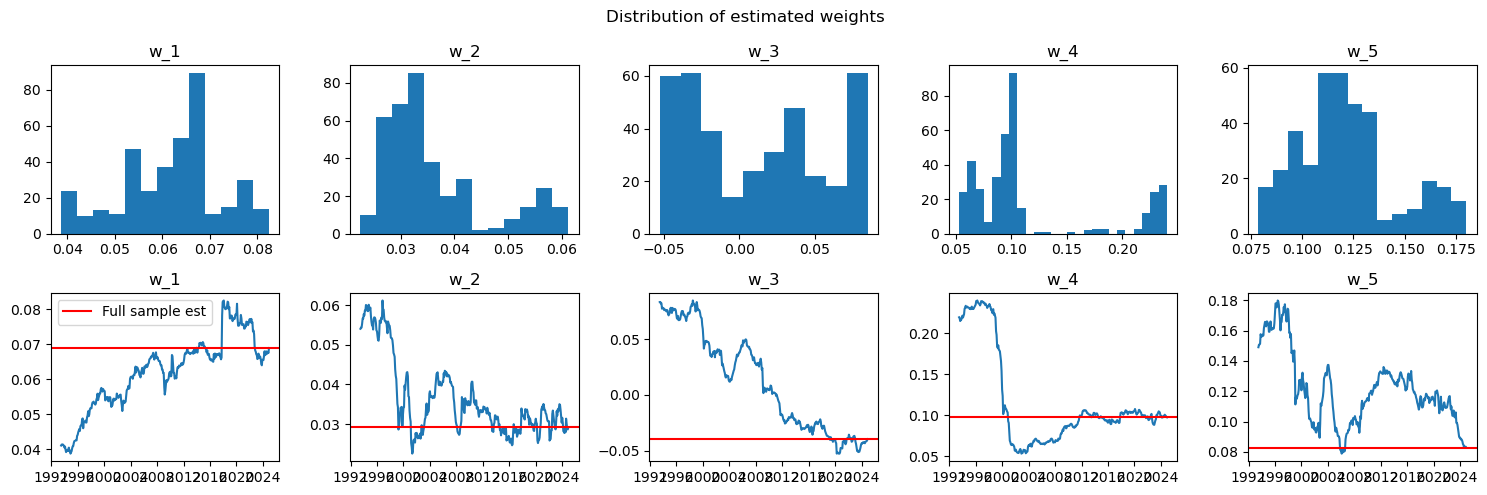

In [47]:
# Look at the distribution of weights estimates
fig, axes = plt.subplots(2, 5, figsize=(15, 5))  # 1 row, 5 columns

for (i) in range(5):
    axes[0,i].hist(weights_est[:, i], bins='auto')  # Plot histogram for column i
    axes[0,i].set_title(f'w_{i+1}')          # Set subplot title
    axes[1,i].plot(factors.iloc[window_size:].index,weights_est[:, i])
    axes[1, i].axhline(y=w_F[i], color='r', label='Full sample est') # Add horizontal line
    axes[1,i].set_title(f'w_{i+1}')
axes[1, 0].legend()    
plt.suptitle('Distribution of estimated weights')
plt.tight_layout()  # Prevent overlapping titles/labels
plt.show()

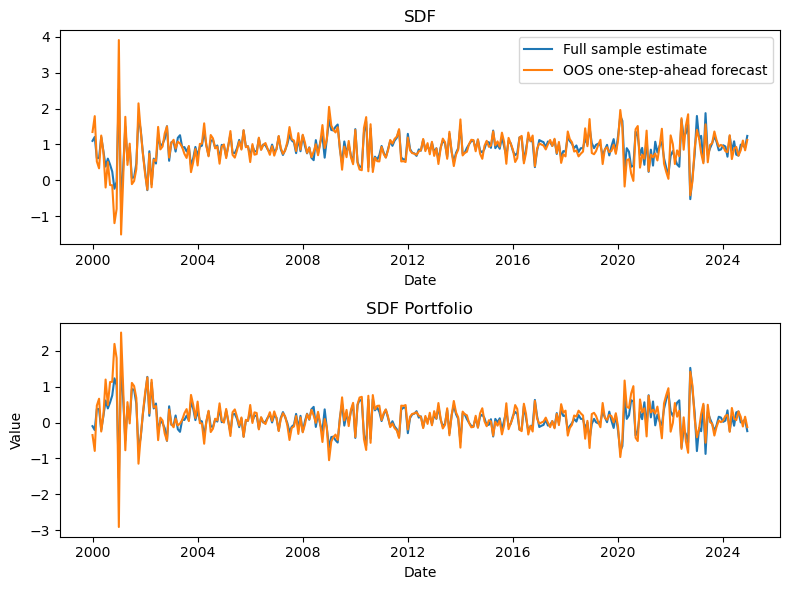

In [33]:
# Plot the full sample vs OOS estimates
# start plot date
startplt = '2000-01-01'

fig, axes = plt.subplots(2, 1, figsize=(8, 6))  # 

axes[0].plot(sdf_df.loc[startplt:]['SDF'], label='SDF (In-Sample)')
axes[0].plot(sdf_df.loc[startplt:]['sdf_OOS'], label='SDF (Out-of-Sample)')
axes[0].set_title('SDF')
axes[0].set_xlabel('Date')  
axes[0].legend(['Full sample estimate','OOS one-step-ahead forecast'])  

axes[1].plot(sdf_df.loc[startplt:]['PORT'], label='PORT (In-Sample)')
axes[1].plot(sdf_df.loc[startplt:]['sdf_port_OOS'], label='PORT (Out-of-Sample)')
axes[1].set_title('SDF Portfolio')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')

plt.tight_layout()
plt.show()

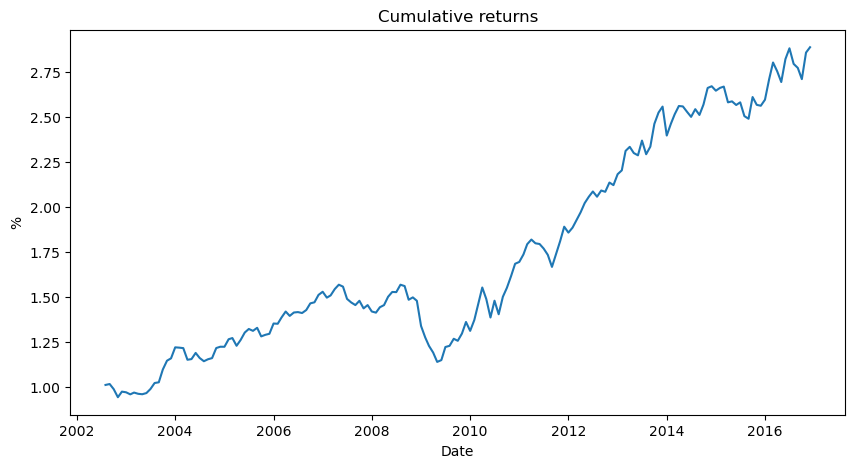

Sharpe ratio of OOS SDF portfolio: 0.79
Pricing error for 25 FF portfolios: 0.18


In [110]:
# now computing the metrics as in Figure 3 in the paper
sdf_port_OOS_samp = sdf_port_OOS[start_date:end_date]
sdf_OOS_samp = sdf_OOS[start_date:end_date]
T_sample = sdf_OOS_samp.shape[0]

# plot cumulative returns
temp1 = sdf_port_OOS_samp*(.1/(np.sqrt(12)*sdf_port_OOS_samp.std()))
plt.figure(figsize=(10, 5))
plt.plot((temp1+1).cumprod())
plt.xlabel("Date")
plt.ylabel("%")
plt.title("Cumulative returns")
plt.show()

# print Sharpe
print(f'Sharpe ratio of OOS SDF portfolio: {np.sqrt(12)*sdf_port_OOS_samp.mean()/sdf_port_OOS_samp.std():.2f}')

# pricing errors
testassets_sample = testassets.loc[start_date:end_date]
p_err_sample = ((sdf_OOS_samp@testassets_sample)/T_sample) @ np.linalg.pinv(((testassets_sample.T)@testassets_sample)/T_sample) @ ((sdf_OOS_samp@testassets_sample)/T_sample)
print(f'Pricing error for 25 FF portfolios: {p_err_sample:.2f}')

Pretty close to the results in the paper !

# 2. Loading and treating the TFP series

I have detrended the latest series from Fernald's website using Matlab (in the folder 'post_PHD_ch1_research')  
I will fit the estimated SDF process estimated in 1. applying Kelly's technique on TFP and VIX series to see how it compares  
To deal with the frequency missmatch (SDF at monthly, TFP at quarterly), I will investigate two methods
1. Use a Kalman filter to interpolate the quarterly series
2. derive the quarterly SDF portfolio from the monthly one, and obtain the corresponding quarterly SDF

## 2.0. Loading the TFP series

In [165]:
# note the tfp series starts in 1963-Q3 for consistency with the 1963-07 of the monthly samples
tfp_df = pd.read_csv('tfp.csv')
# Create the DatetimeIndex
date_index = pd.date_range(start='1963Q3', end='2024Q4', freq='QS')
tfp_df.index = date_index
tfp_df=tfp_df.drop('date',axis=1)
tfp_df.rename(columns={'tfp':'tfp_q'}, inplace=True)
tfp_df

,tfp_q
1963-07-01,-0.001304
1963-10-01,0.002792
1964-01-01,0.010345
1964-04-01,0.004505
1964-07-01,0.005791
...,...
2023-10-01,0.001734
2024-01-01,0.006743
2024-04-01,0.009238
2024-07-01,0.008105


## 2.1. Interpolating TFP: Kalman filter

The Kalman filter model is straigthforward:
$$
\begin{align*} a^m_t &= \rho a^m_{t-1} + \sigma_{a^m}\varepsilon_t \\ a^q_t &= a^m_{3t} \end{align*}
$$
where $\varepsilon_t \sim \mathcal{N}(0,1)$ is the monthly AR(1) innovation

In [281]:
# Define the parameters and the series to use in the Kalman filter

# quarterly AR(1) estimate from matlab
rho_quarterly = 0.876208214307874
sigma_quarterly = 0.00951694323705093
rho_monthly = rho_quarterly ** (1/3)
sigma_monthly = np.sqrt(sigma_quarterly**2 / (1 + rho_monthly**2 + rho_monthly**4))

# Prepare monthly data with NaN for missing months
tfp_m = np.full(sdf_df.shape[0], np.nan)
tfp_m[::3] = tfp_df['tfp_q']


In [297]:
# Method 1: use the Kalman filter from the filterpy library

from filterpy.kalman import KalmanFilter

# Initialize Kalman Filter
kf = KalmanFilter(dim_x=1, dim_z=1)  # state dimension, observation dimension

# Set state transition matrix (F)
kf.F = np.array([[rho_monthly]])
# Set observation matrix (H)
kf.H = np.array([[1.]])
# Set process noise covariance (Q)
kf.Q = np.array([[sigma_monthly**2]])
# Set measurement noise covariance (R)
kf.R = np.array([[1e-6]])
# Set initial state mean (x)
kf.x = np.array([[tfp_df['tfp_q'].iloc[0]]])
# Set initial state covariance (P)
kf.P = np.array([[sigma_monthly**2]])

# Perform filtering
filtered_state_means, filtered_state_covariances = [], []
for z in tfp_m:
    if np.isnan(z):
        kf.predict()
    else:
        kf.update(z)
    filtered_state_means.append(kf.x[0, 0])
    filtered_state_covariances.append(kf.P[0,0])

filtered_state_means_pyfilter = np.array(filtered_state_means)

In [299]:
# Method 2: code the filter and smoother directly

# Initialize parameters
F = np.array([[rho_monthly]])  # State transition matrix
H = np.array([[1.]])          # Observation matrix
Q = np.array([[sigma_monthly**2]])  # Process noise covariance
R = np.array([[1e-6]])          # Measurement noise covariance
x_init = np.array([[tfp_df['tfp_q'].iloc[0]]])  # Initial state estimate
P_init = np.array([[sigma_monthly**2]])  # Initial state covariance

# Kalman Filter implementation
def kalman_filter(z, F, H, Q, R, x_init, P_init):
    """
    Args:
        z (np.ndarray): Observations (measurements) at each time step.  Can contain NaNs.
        F (np.ndarray): State transition matrix.
        H (np.ndarray): Observation matrix.
        Q (np.ndarray): Process noise covariance matrix.
        R (np.ndarray): Measurement noise covariance matrix.
        x_init (np.ndarray): Initial state estimate.
        P_init (np.ndarray): Initial state covariance matrix.

    Returns:
        tuple: (x_filtered, P_filtered)
            - x_filtered:  Filtered state estimates at each time step.
            - P_filtered:  Filtered state covariance matrices at each time step.
    """
    n_timesteps = len(z)
    x = x_init
    P = P_init
    x_filtered = np.zeros((n_timesteps, x.shape[0], x.shape[1]))
    P_filtered = np.zeros((n_timesteps, P.shape[0], P.shape[1]))

    for t in range(n_timesteps):
        # Predict
        x_pred = F @ x
        P_pred = F @ P @ F.T + Q

        # Update
        if np.isnan(z[t]):
            x = x_pred
            P = P_pred
        else:
            y = z[t] - H @ x_pred
            S = H @ P_pred @ H.T + R
            K = P_pred @ H.T @ np.linalg.inv(S)
            x = x_pred + K @ y
            P = (np.eye(P.shape[0]) - K @ H) @ P_pred

        x_filtered[t] = x
        P_filtered[t] = P

    return x_filtered, P_filtered


def rts_smoother(x_filtered, P_filtered, F, Q):
    """
    Args:
        x_filtered (np.ndarray): Filtered state estimates from the Kalman filter.
        P_filtered (np.ndarray): Filtered state covariance matrices from the Kalman filter.
        F (np.ndarray): State transition matrix.
        Q (np.ndarray): Process noise covariance matrix.

    Returns:
        tuple: (x_smoothed, P_smoothed)
            - x_smoothed: Smoothed state estimates at each time step.
            - P_smoothed: Smoothed state covariance matrices at each time step.
    """
    n_timesteps = x_filtered.shape[0]
    x_smoothed = np.zeros_like(x_filtered)
    P_smoothed = np.zeros_like(P_filtered)

    x_smoothed[-1] = x_filtered[-1]
    P_smoothed[-1] = P_filtered[-1]

    for t in reversed(range(n_timesteps - 1)):
        x_pred = F @ x_filtered[t]
        P_pred = F @ P_filtered[t] @ F.T + Q
        G = P_filtered[t] @ F.T @ np.linalg.inv(P_pred)

        x_smoothed[t] = x_filtered[t] + G @ (x_smoothed[t + 1] - x_pred)
        P_smoothed[t] = P_filtered[t] + G @ (P_smoothed[t + 1] - P_pred) @ G.T

    return x_smoothed, P_smoothed

# Apply the Kalman Filter
filtered_state_means, P_filtered = kalman_filter(tfp_m, F, H, Q, R, x_init, P_init)
# Apply the RTS Smoother
smoothed_state_means, P_smoothed = rts_smoother(filtered_state_means, P_filtered, F, Q)

filtered_state_means = filtered_state_means.flatten()
smoothed_state_means = smoothed_state_means.flatten()

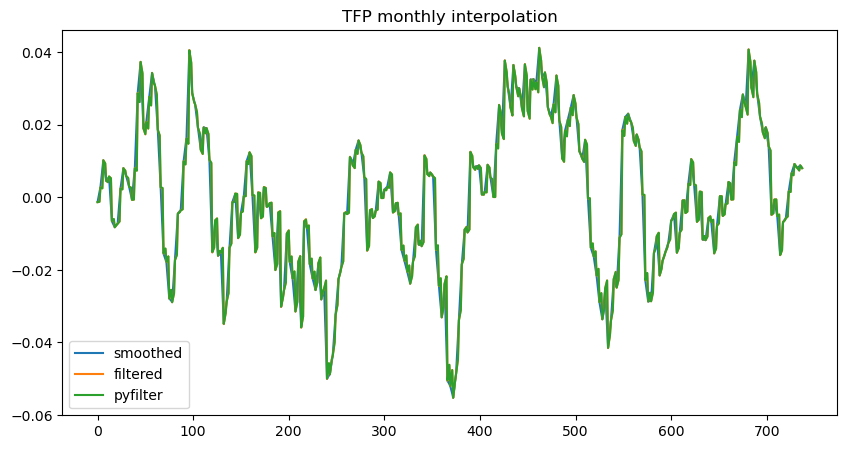

In [301]:
# Plotting the results to see and understand 

plt.figure(figsize=(10, 5))
plt.plot(smoothed_state_means)
plt.plot(filtered_state_means)
plt.plot(filtered_state_means_pyfilter)
plt.title("TFP monthly interpolation")
plt.legend(['smoothed','filtered','pyfilter'])
plt.show()

So Clearly all three methods give the same result

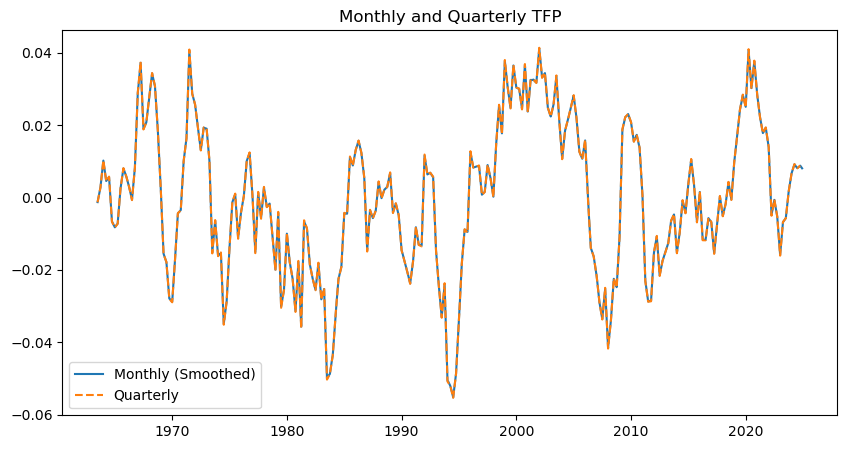

In [323]:
# Create a figure and axis
plt.figure(figsize=(10, 5))
plt.plot(sdf_df.index, smoothed_state_means, label='Monthly (Smoothed)')
plt.plot(tfp_df.index, tfp_df['tfp_q'], '--', label='Quarterly')  # 'o-' for points and lines
plt.title('Monthly and Quarterly TFP')
plt.legend()
plt.show()

In [340]:
# Store for easier use
sdf_df['tfp_m'] = smoothed_state_means

# 3. Estimating the SDF process

## 3.1. Only productivity

### 3.1.1. Linear specification

Note: there's a problem with negative SDF values, when taking the log. Just to be aware

In [381]:
# Define dependent (y) and independent (X) variables
y = np.log(sdf_df['SDF'].shift(-1))  # M_{t+1}
x1 = sdf_df['tfp_m']
x2 = sdf_df['tfp_m'].shift(-1)

# Combine x1 and x2 into a single DataFrame
X = pd.DataFrame({'x1': x1, 'x2': x2})

X = sm.add_constant(X)  # Adds intercept (c0)

# Drop rows where y or any column in X is NaN
data = pd.concat([y.to_frame(), X], axis=1).dropna() # Convert y to DataFrame
y = data.iloc[:, 0]  # First column of cleaned data is y
X = data.iloc[:, 1:] # Remaining columns are X

# Fit OLS
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    SDF   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.352
Date:                Sun, 11 May 2025   Prob (F-statistic):             0.0356
Time:                        20:13:54   Log-Likelihood:                -292.63
No. Observations:                 730   AIC:                             591.3
Df Residuals:                     727   BIC:                             605.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1584      0.013    -11.821      0.0

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


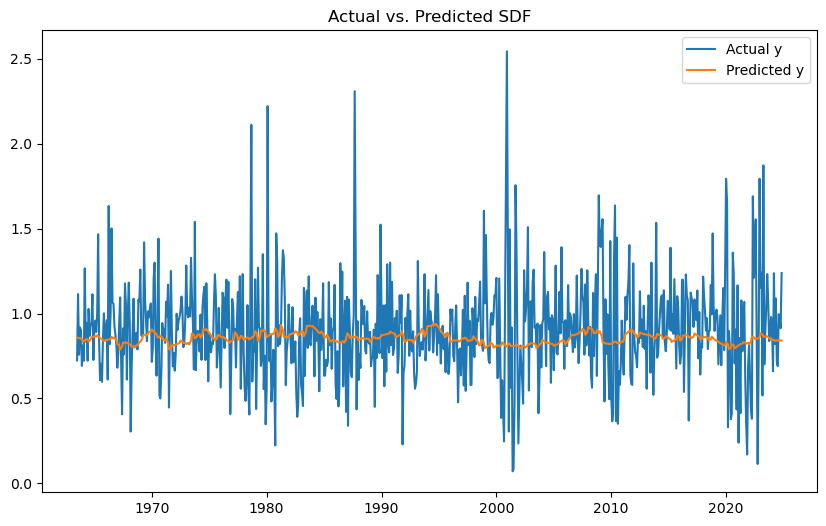

In [389]:
# Get the estimated (predicted) values
y_predicted = model.fittedvalues

# Plot the actual y values against the predicted y values
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(np.exp(y), label='Actual y')
plt.plot(np.exp(y_predicted), label='Predicted y')
plt.title('Actual vs. Predicted SDF')
plt.legend()
plt.show()


### 3.1.2. Conditional linear specification

In [400]:
# Define dependent (y) and independent (X) variables
y = np.log(sdf_df['SDF'].shift(-1))  # M_{t+1}
x1 = sdf_df['tfp_m']
x2 = sdf_df['tfp_m'] - sdf_df['tfp_m'].shift(-1)
x3 = x1 * x2

# Combine x1 and x2 into a single DataFrame
X = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})

X = sm.add_constant(X)  # Adds intercept (c0)

# Drop rows where y or any column in X is NaN
data = pd.concat([y.to_frame(), X], axis=1).dropna() # Convert y to DataFrame
y = data.iloc[:, 0]  # First column of cleaned data is y
X = data.iloc[:, 1:] # Remaining columns are X

# Fit OLS
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    SDF   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.644
Date:                Sun, 11 May 2025   Prob (F-statistic):             0.0482
Time:                        20:20:40   Log-Likelihood:                -292.02
No. Observations:                 730   AIC:                             592.0
Df Residuals:                     726   BIC:                             610.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1574      0.013    -11.716      0.0

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


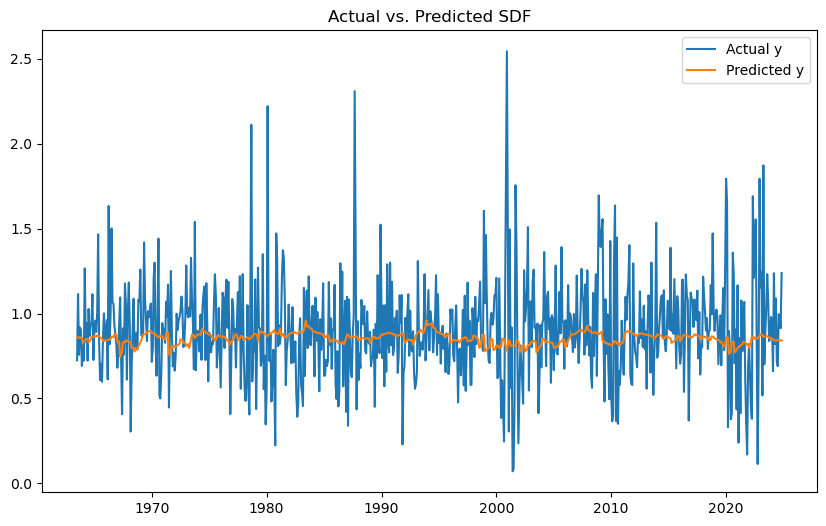

In [402]:
# Get the estimated (predicted) values
y_predicted = model.fittedvalues

# Plot the actual y values against the predicted y values
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(np.exp(y), label='Actual y')
plt.plot(np.exp(y_predicted), label='Predicted y')
plt.title('Actual vs. Predicted SDF')
plt.legend()
plt.show()

## 3.2. Productivity and uncertainty (VIX)

In [420]:
# note the tfp series starts in 1963-Q3 for consistency with the 1963-07 of the monthly samples
vix_df = pd.read_csv('vix.csv')
vix_df.index = pd.to_datetime(vix_df['sasdate'], format='%m/%d/%Y')
vix_df=vix_df.drop('sasdate',axis=1)
vix_df

,VIXCLSx
sasdate,
1963-07-01,14.2966
1963-08-01,11.4839
1963-09-01,13.0301
1963-10-01,13.8203
1963-11-01,28.6666
...,...
2024-08-01,19.6750
2024-09-01,17.6597
2024-10-01,19.9478


### 3.2.1. Linear 

In [423]:
y = np.log(sdf_df['SDF'].shift(-1))  # M_{t+1}
x1 = sdf_df['tfp_m']
x2 = sdf_df['tfp_m'].shift(-1)
x3 = vix_df['VIXCLSx']
x4 = vix_df['VIXCLSx'].shift(-1)

# Combine x1 and x2 into a single DataFrame
X = pd.DataFrame({'x1':x1, 'x2':x2,'x3':x3,'x4':x4})

X = sm.add_constant(X)  # Adds intercept (c0)

# Drop rows where y or any column in X is NaN
data = pd.concat([y.to_frame(), X], axis=1).dropna() # Convert y to DataFrame
y = data.iloc[:, 0]  # First column of cleaned data is y
X = data.iloc[:, 1:] # Remaining columns are X

# Fit OLS
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    SDF   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     7.028
Date:                Sun, 11 May 2025   Prob (F-statistic):           1.49e-05
Time:                        23:28:22   Log-Likelihood:                -282.10
No. Observations:                 730   AIC:                             574.2
Df Residuals:                     725   BIC:                             597.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1569      0.040     -3.885      0.0

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


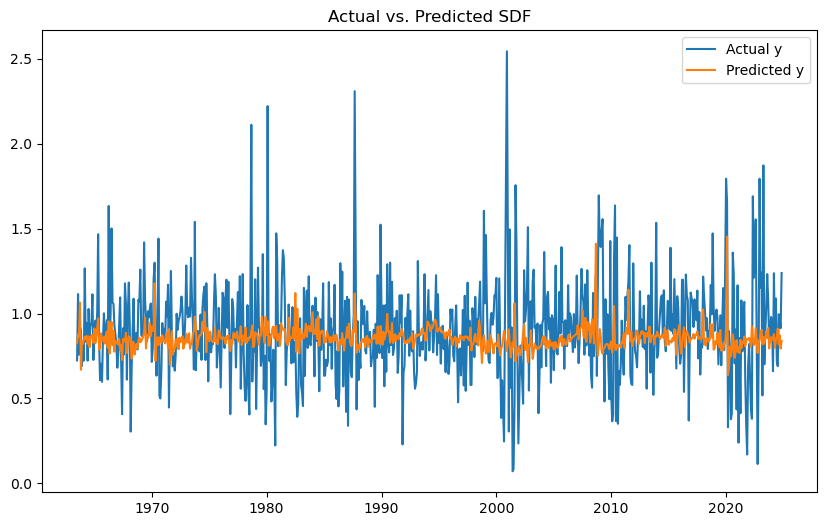

In [425]:
y_predicted = model.fittedvalues

# Plot the actual y values against the predicted y values
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(np.exp(y), label='Actual y')
plt.plot(np.exp(y_predicted), label='Predicted y')
plt.title('Actual vs. Predicted SDF')
plt.legend()
plt.show()

### 2.2.2. Conditional linear

In [427]:
y = np.log(sdf_df['SDF'].shift(-1))  # M_{t+1}
x1 = sdf_df['tfp_m']
x2 = sdf_df['tfp_m'] - sdf_df['tfp_m'].shift(-1)
x3 = x1 * x2
x4 = vix_df['VIXCLSx']
x5 = vix_df['VIXCLSx'] - vix_df['VIXCLSx'].shift(-1)
x6 = x4 * x5

# Combine x1 and x2 into a single DataFrame
X = pd.DataFrame({'x1':x1, 'x2':x2,'x3':x3,'x4':x4,'x5':x5,'x6':x6})

X = sm.add_constant(X)  # Adds intercept (c0)

# Drop rows where y or any column in X is NaN
data = pd.concat([y.to_frame(), X], axis=1).dropna() # Convert y to DataFrame
y = data.iloc[:, 0]  # First column of cleaned data is y
X = data.iloc[:, 1:] # Remaining columns are X

# Fit OLS
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    SDF   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     5.242
Date:                Sun, 11 May 2025   Prob (F-statistic):           2.68e-05
Time:                        23:30:53   Log-Likelihood:                -280.44
No. Observations:                 730   AIC:                             574.9
Df Residuals:                     723   BIC:                             607.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1401      0.042     -3.361      0.0

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


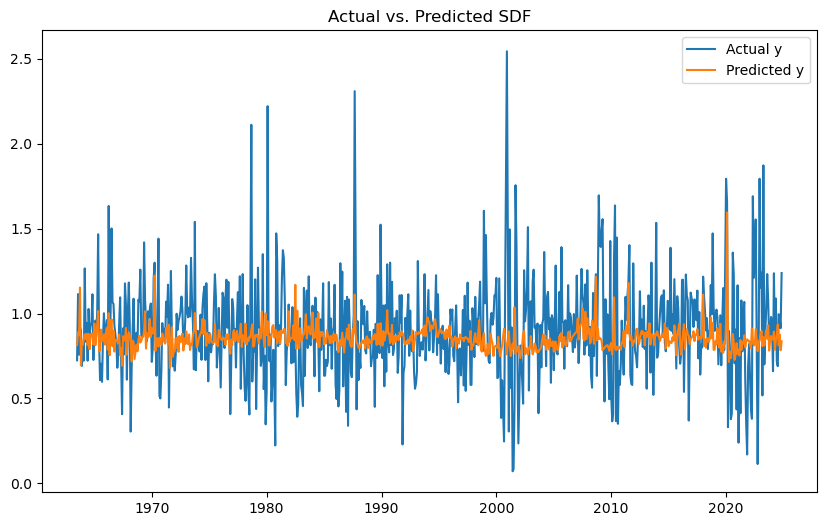

In [429]:
y_predicted = model.fittedvalues

# Plot the actual y values against the predicted y values
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(np.exp(y), label='Actual y')
plt.plot(np.exp(y_predicted), label='Predicted y')
plt.title('Actual vs. Predicted SDF')
plt.legend()
plt.show()

In [431]:
y = np.log(sdf_df['SDF'].shift(-1))  # M_{t+1}
x1 = sdf_df['tfp_m']
x2 = sdf_df['tfp_m'] - sdf_df['tfp_m'].shift(-1)
x3 = vix_df['VIXCLSx']
x4 = vix_df['VIXCLSx'] - vix_df['VIXCLSx'].shift(-1)
x5 = x1 * x4
x6 = x2 * x3

# Combine x1 and x2 into a single DataFrame
X = pd.DataFrame({'x1':x1, 'x2':x2,'x3':x3,'x4':x4,'x5':x5,'x6':x6})

X = sm.add_constant(X)  # Adds intercept (c0)

# Drop rows where y or any column in X is NaN
data = pd.concat([y.to_frame(), X], axis=1).dropna() # Convert y to DataFrame
y = data.iloc[:, 0]  # First column of cleaned data is y
X = data.iloc[:, 1:] # Remaining columns are X

# Fit OLS
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    SDF   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     5.608
Date:                Sun, 11 May 2025   Prob (F-statistic):           1.06e-05
Time:                        23:35:44   Log-Likelihood:                -279.38
No. Observations:                 730   AIC:                             572.8
Df Residuals:                     723   BIC:                             604.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1292      0.042     -3.064      0.0

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## 3.3. Quarterly Analysis

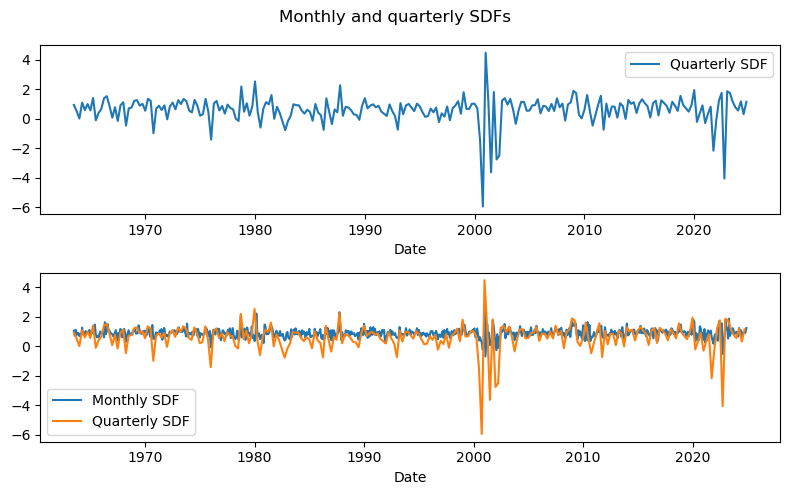

In [572]:
# Obtain quarterly SDF portfolio returns
# Calculate quarterly returns using the compounding formula
sdf_port_q = (sdf_df['PORT'].resample('QE').apply(lambda x: (x + 1).prod() - 1))
sdf_q = 1 - sdf_port_q
# Create a DataFrame with sdf_q
sdf_q_df = pd.DataFrame({'sdf_q': sdf_q})
sdf_q_df.index = tfp_df.index

# plot
fig, axes = plt.subplots(2, 1, figsize=(8, 5))  

# Plot tfp_q
axes[0].plot(tfp_df.index, sdf_q, label='Quarterly SDF') 
axes[0].set_xlabel('Date')  
axes[0].legend()

# Plot SDF
axes[1].plot(sdf_df.index, sdf_df['SDF'], label='Monthly SDF')
axes[1].plot(tfp_df.index, sdf_q, label='Quarterly SDF')
axes[1].set_xlabel('Date')
axes[1].legend()

plt.suptitle('Monthly and quarterly SDFs')
plt.tight_layout()
plt.show()

In [518]:
# VIX at the quarterly
vix_df_q = vix_df.resample('QE').first()['VIXCLSx'].to_frame()
vix_df_q.index = tfp_df.index

In [576]:
# now proceed with regression
y = sdf_q_df['sdf_q'].shift(-1)  # M_{t+1}
x1 = tfp_df['tfp_q']
x2 = tfp_df['tfp_q'].shift(-1)
x3 = vix_df_q['VIXCLSx']
x4 = vix_df_q['VIXCLSx'].shift(-1)

# Combine x1 and x2 into a single DataFrame
X = pd.DataFrame({'a_t':x1, 'a_{t+1}':x2,'vix_t':x3,'vix_{t+1}':x4})

X = sm.add_constant(X)  # Adds intercept (c0)

# Drop rows where y or any column in X is NaN
data = pd.concat([y.to_frame(), X], axis=1).dropna()  # Convert y to DataFrame
y = data.iloc[:, 0]  # First column of cleaned data is y
X = data.iloc[:, 1:]  # Remaining columns are X

# Fit OLS
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  sdf_q   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.407
Date:                Mon, 12 May 2025   Prob (F-statistic):              0.232
Time:                        09:06:39   Log-Likelihood:                -328.45
No. Observations:                 245   AIC:                             666.9
Df Residuals:                     240   BIC:                             684.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7193      0.190      3.784      0.0